# Galaxy10 + CNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
BASE = Path().resolve().parent
print(f'BASE: {BASE}')

import torch
torch.manual_seed(0)

IS_MPS_AVAILABLE = torch.backends.mps.is_available() and torch.backends.mps.is_built()
print(f'Is mps avaliable? : {IS_MPS_AVAILABLE}')

import h5py
from tqdm import tqdm

from sklearn.model_selection import train_test_split

BASE: /Users/zheng/Documents/Study/SDSSGalCat
Is mps avaliable? : True


In [2]:
# load data
# data ref: https://astronn.readthedocs.io/en/stable/galaxy10sdss.html

with h5py.File(BASE / 'data/Galaxy10.h5', 'r') as f:
    images = f['images'][:]
    labels = f['ans'][:]

print(f'images.shape: {images.shape}, labels.shape: {labels.shape}')
assert images.shape[0] == labels.shape[0]

images.shape: (21785, 69, 69, 3), labels.shape: (21785,)


In [3]:
# split the data, 90% for training and 10% for testing
# make sure that there are equal number of samples for each class in the training and testing set
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=0)
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')

X_train.shape: (17428, 69, 69, 3), y_train.shape: (17428,)
X_test.shape: (4357, 69, 69, 3), y_test.shape: (4357,)


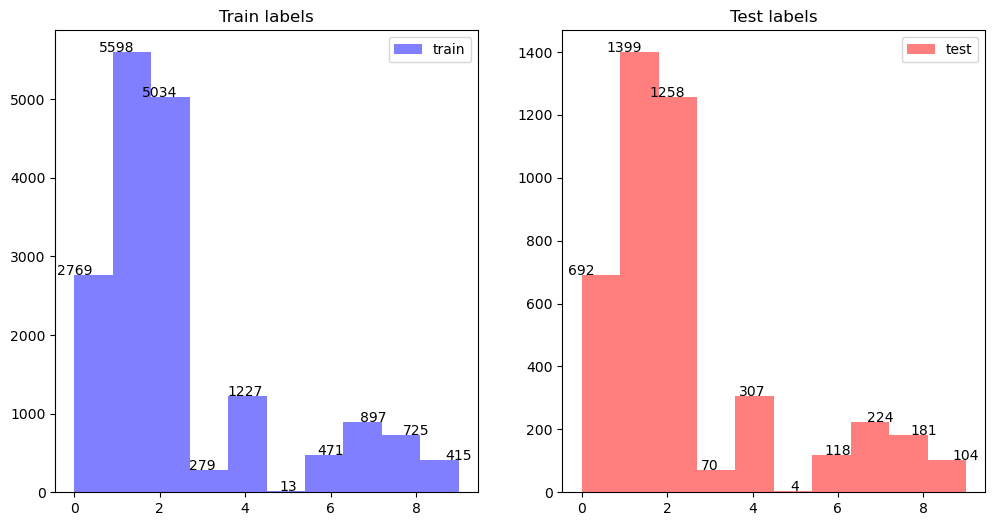

In [4]:
# visualize the splited data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(y_train, bins=10, color='blue', alpha=0.5, label='train')
for i in range(10):
    ax[0].text(i, y_train.tolist().count(i), str(y_train.tolist().count(i)), color='black', ha='center')
ax[0].set_title('Train labels')
ax[0].legend()

ax[1].hist(y_test, bins=10, color='red', alpha=0.5, label='test')
for i in range(10):
    ax[1].text(i, y_test.tolist().count(i), str(y_test.tolist().count(i)), color='black', ha='center')
ax[1].set_title('Test labels')
ax[1].legend()

plt.show()
plt.close()

In [5]:
# built a torch CNN 
# ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # input is a 3 channel image with 69x69 pixels, output is 10 classes
        # cov calculator: http://www.sqflash.com/cal.html

        self.conv1 = torch.nn.Conv2d(3, 6, 5)   # out 65*65, 32*32 after pool
        self.conv2 = torch.nn.Conv2d(6, 16, 5)  # out 28*28, 14*14 after pool

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(16 * 14 * 14, 512)   # 3136 -> 512
        self.fc2 = torch.nn.Linear(512, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_CNN = CNN()

In [6]:
# define the optimizer and loss function
crit = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(net_CNN.parameters(), lr=0.001, momentum=0.9)

Epoch 1/32: 35it [00:09,  3.79it/s]                        


Epoch 1 loss: 1.7884421393442844


Epoch 2/32: 35it [00:09,  3.81it/s]                        


Epoch 2 loss: 1.616295829179338


Epoch 3/32: 35it [00:09,  3.83it/s]                        


Epoch 3 loss: 1.4647841191986763


Epoch 4/32: 35it [00:09,  3.89it/s]                        


Epoch 4 loss: 1.2969209724865787


Epoch 5/32: 35it [00:09,  3.88it/s]                        


Epoch 5 loss: 1.165167807876065


Epoch 6/32: 35it [00:09,  3.89it/s]                        


Epoch 6 loss: 1.0121940138254084


Epoch 7/32: 35it [00:09,  3.80it/s]                        


Epoch 7 loss: 0.9227212429156072


Epoch 8/32: 35it [00:09,  3.84it/s]                        


Epoch 8 loss: 0.8749323860888145


Epoch 9/32: 35it [00:08,  3.89it/s]                        


Epoch 9 loss: 0.8176934130836961


Epoch 10/32: 35it [00:09,  3.82it/s]                        


Epoch 10 loss: 0.8672513316086408


Epoch 11/32: 35it [00:09,  3.86it/s]                        


Epoch 11 loss: 0.7823234358483946


Epoch 12/32: 35it [00:08,  3.91it/s]                        


Epoch 12 loss: 0.7433761174672783


Epoch 13/32: 35it [00:09,  3.88it/s]                        


Epoch 13 loss: 0.7045958227648329


Epoch 14/32: 35it [00:08,  3.92it/s]                        


Epoch 14 loss: 0.6702237044941375


Epoch 15/32: 35it [00:08,  3.90it/s]                        


Epoch 15 loss: 0.6478396169029027


Epoch 16/32: 35it [00:08,  3.91it/s]                        


Epoch 16 loss: 0.6208116642126994


Epoch 17/32: 35it [00:09,  3.79it/s]                        


Epoch 17 loss: 0.601212666782732


Epoch 18/32: 35it [00:09,  3.82it/s]                        


Epoch 18 loss: 0.5777217767806072


Epoch 19/32: 35it [00:09,  3.83it/s]                        


Epoch 19 loss: 0.5806089519004305


Epoch 20/32: 35it [00:09,  3.85it/s]                        


Epoch 20 loss: 0.5835732873054664


Epoch 21/32: 35it [00:09,  3.87it/s]                        


Epoch 21 loss: 0.5691549109843501


Epoch 22/32: 35it [00:09,  3.87it/s]                        


Epoch 22 loss: 0.5473998945077296


Epoch 23/32: 35it [00:08,  3.90it/s]                        


Epoch 23 loss: 0.5071577006916347


Epoch 24/32: 35it [00:08,  3.91it/s]                        


Epoch 24 loss: 0.5072073202109102


Epoch 25/32: 35it [00:08,  3.90it/s]                        


Epoch 25 loss: 0.47922179182926833


Epoch 26/32: 35it [00:08,  3.90it/s]                        


Epoch 26 loss: 0.4724054798391507


Epoch 27/32: 35it [00:09,  3.87it/s]                        


Epoch 27 loss: 0.4815781586537373


Epoch 28/32: 35it [00:09,  3.89it/s]                        


Epoch 28 loss: 0.4960462225668196


Epoch 29/32: 35it [00:09,  3.85it/s]                        


Epoch 29 loss: 0.48706103410911256


Epoch 30/32: 35it [00:09,  3.87it/s]                        


Epoch 30 loss: 0.44619506932683894


Epoch 31/32: 35it [00:09,  3.86it/s]                        


Epoch 31 loss: 0.4210691751896419


Epoch 32/32: 35it [00:09,  3.84it/s]                        

Epoch 32 loss: 0.39538590777267796


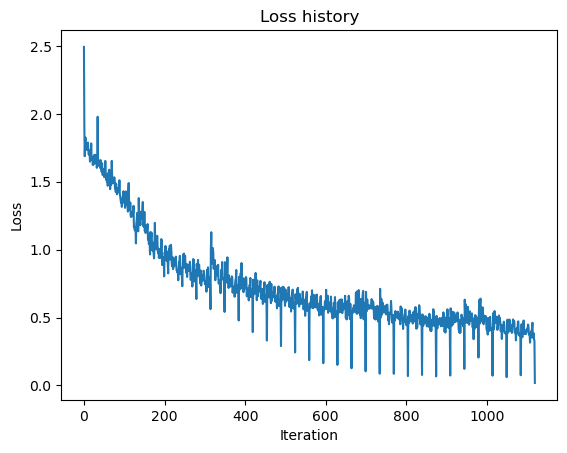

In [7]:
EPOCH_NUM = 32
BATCH_SIZE = 512

# train the model
loss_history = []
for epoch in range(EPOCH_NUM):
    running_loss = 0.0
    for i in tqdm(
            range(0, X_train.shape[0], BATCH_SIZE), 
            # show running loss
            desc=f'Epoch {epoch+1}/{EPOCH_NUM}',
            total=X_train.shape[0]//BATCH_SIZE, 
            # realtime progress bar
            dynamic_ncols=True,
        ):
        # transpose the data to torch tensor
        this_inputs = torch.tensor(X_train[i:i+BATCH_SIZE]).permute(0, 3, 1, 2).float()
        this_labels = torch.tensor(y_train[i:i+BATCH_SIZE]).long()

        optim.zero_grad()

        outputs = net_CNN(this_inputs)
        loss = crit(outputs, this_labels)
        loss.backward()
        optim.step()

        loss_history.append(loss.item())
        running_loss += loss.item()

    print(f'Epoch {epoch+1} loss: {running_loss / (X_train.shape[0] / BATCH_SIZE)}')

# show history
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()
plt.close()

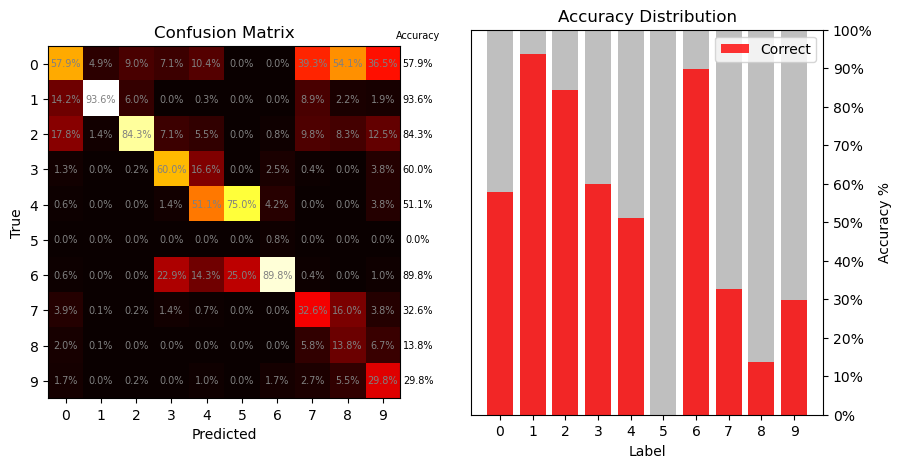

In [8]:
# test the model: confusion table
resmat_count = np.zeros((10, 10))

with torch.no_grad():
    test_inputs = torch.tensor(X_test).permute(0, 3, 1, 2).float()
    test_labels = torch.tensor(y_test).long()

    outputs = net_CNN(test_inputs)
    _, predicted = torch.max(outputs, 1)

    for i in range(10): # 10 classes
        for j in range(10):
            resmat_count[i, j] = torch.sum((predicted == i) & (test_labels == j)).item()

# normalize the confusion matrix
resmat = resmat_count / np.sum(resmat_count, axis=0)

# a beautiful table
fig = plt.figure(figsize=(10, 5), dpi=100)

ax = fig.add_subplot(121)
# confustion matrix
ax.matshow(resmat, cmap='hot')
# accuracy
for i in range(10):
    for j in range(10):
        ax.text(j, i, f'{resmat[i, j]*100:.1f}%', ha='center', va='center', color='grey', fontsize=7)
# accuracy on the right
for i in range(10):
    ax.text(10, i, f'{resmat[i, i]*100:.1f}%', ha='center', va='center', color='black', fontsize=7)
ax.text(10, -0.8, f'Accuracy', ha='center', va='center', color='black', fontsize=7)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
xticks = np.arange(0, 10, 1)
ax.set_xticks(xticks)
yticks = np.arange(0, 10, 1)
ax.set_yticks(yticks)
ax.xaxis.tick_bottom()

# show predict distribution, using stacked bar plot, normalized to 100%
# only show True or False
resmat_true = resmat.diagonal()
resmat_false = resmat - np.diag(resmat_true)
ax2 = fig.add_subplot(122)
# true on bottom, false on top
ax2.bar(range(10), [100]*10, color='grey', alpha=0.5)
ax2.bar(range(10), resmat_true*100, color='red', label='Correct', alpha=0.8)
# ax2.bar(range(10), resmat_false*100, bottom=resmat_true*100, color='red', label='False')
ax2.set_xticks(range(10))
ax2.set_xticklabels(range(10))
ax2.set_xlabel('Label')
ax2.set_ylabel('Accuracy %')
ax2.set_title('Accuracy Distribution')
ax2.set_ylim(0, 100)
ax2.legend()
# ylabel right
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
# add % to ylabel
yticks = np.arange(0, 101, 10)
ax2.set_yticks(yticks)
ax2.set_yticklabels([f'{int(y)}%' for y in yticks])


plt.show()
plt.close()

In [9]:
# total accuracy
from sklearn.metrics import accuracy_score
print(f'Total accuracy: {accuracy_score(y_test, predicted)}')

Total accuracy: 0.7355978884553592
